In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dimpo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# FIRST TRY WITH FULL ANNOTATIONS

Our first approach involves annotating 4,170 sentences. The annotations involve assigning a value of 0 if the sentence makes no sense and a value of 1 if it does make sense. Consequently, we have decided to divide the work between two of us to evaluate every sentence as a whole.

In [ ]:
final = pd.read_excel('../data/full_annot.xlsx')

## Data Visualization
Firstly, in order to gain a better understanding of the data, we will perform some data visualization. This is a fundamental step that allows us to observe any patterns in the data that might be difficult to discern simply by examining the sentences.

<AxesSubplot: xlabel='is_valuable', ylabel='count'>

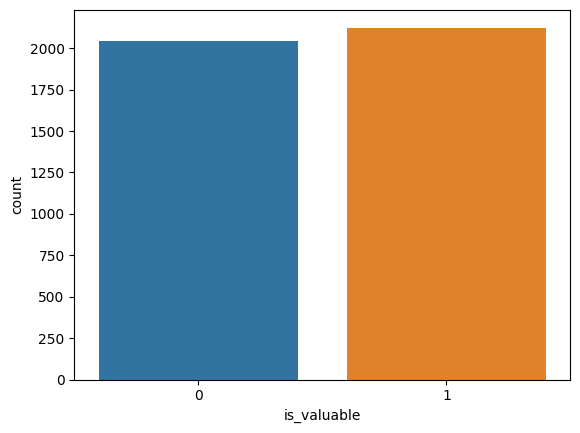

In [99]:
sns.countplot(x="is_valuable",data=final)

In [100]:
final["len_arg1"]=final["arg1"].apply(lambda x: len(word_tokenize(x)))
final["len_rel"]=final["rel"].apply(lambda x: len(word_tokenize(x)))
final["len_arg2"]=final["arg2"].apply(lambda x: len(word_tokenize(x)))

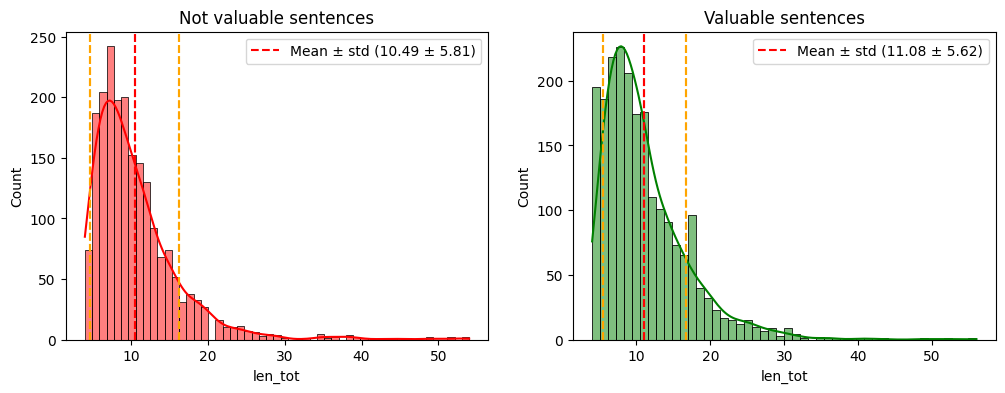

In [101]:
# distribution of the total length of the sentence (arg1+rel+arg2) for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

final["len_tot"] = final["len_arg1"] + final["len_rel"] + final["len_arg2"]
mean = final.groupby("is_valuable")["len_tot"].mean()
std = final.groupby("is_valuable")["len_tot"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable"] == 0]["len_tot"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")
axes[0].axvline(mean[0], color='r', linestyle='--')
axes[0].axvline(mean[0] + std[0], color='orange', linestyle='--')
axes[0].axvline(mean[0] - std[0], color='orange', linestyle='--')

sns.histplot(final[final["is_valuable"] == 1]["len_tot"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")
axes[1].axvline(mean[1], color='r', linestyle='--')
axes[1].axvline(mean[1] + std[1], color='orange', linestyle='--')
axes[1].axvline(mean[1] - std[1], color='orange', linestyle='--')

# Create legend
legend_labels_0 = {'Not valuable': ''}
legend_labels_1 = {'Valuable': ''}
axes[0].legend(handles=[axes[0].axvline(mean[0], color='r', linestyle='--'),
                        axes[0].axvline(mean[0] + std[0], color='orange', linestyle='--'),
                        axes[0].axvline(mean[0] - std[0], color='orange', linestyle='--')],
               labels=[f"Mean ± std ({mean[0]:.2f} ± {std[0]:.2f})"])
axes[1].legend(handles=[axes[1].axvline(mean[1], color='r', linestyle='--'),
                        axes[1].axvline(mean[1] + std[1], color='orange', linestyle='--'),
                        axes[1].axvline(mean[1] - std[1], color='orange', linestyle='--')],
               labels=[f"Mean ± std ({mean[1]:.2f} ± {std[1]:.2f})"])

plt.show()

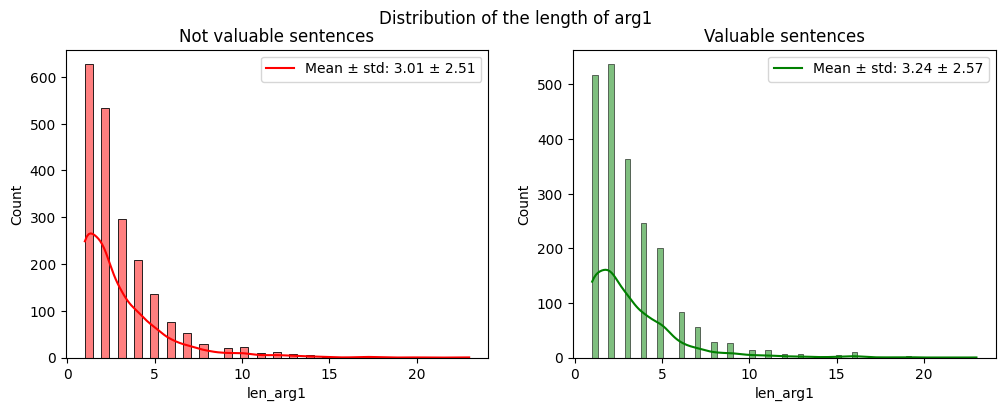

In [102]:
# distribution of the length of the arg1 for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean = final.groupby("is_valuable")["len_arg1"].mean()
std = final.groupby("is_valuable")["len_arg1"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable"] == 0]["len_arg1"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")

sns.histplot(final[final["is_valuable"] == 1]["len_arg1"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")


axes[0].legend(labels=[f"Mean ± std: {mean[0]:.2f} ± {std[0]:.2f}"])
axes[1].legend(labels=[f"Mean ± std: {mean[1]:.2f} ± {std[1]:.2f}"])

# Title
plt.suptitle("Distribution of the length of arg1")

plt.show()


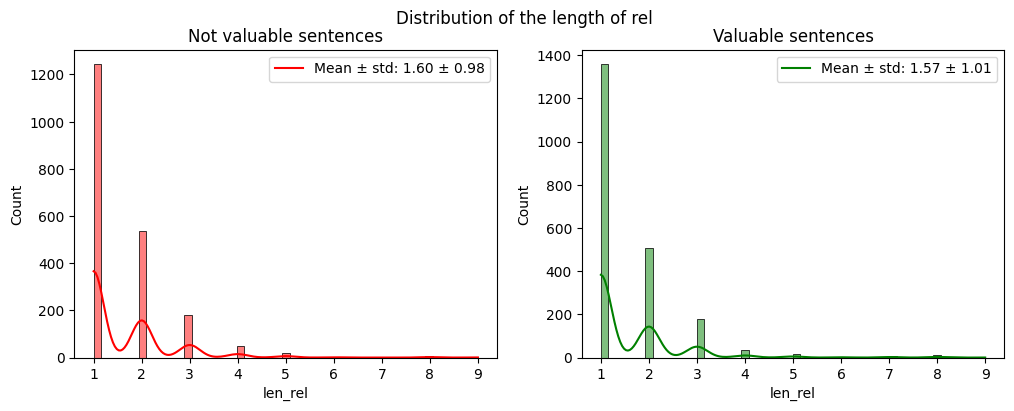

In [103]:
# distribution of the length of the rel for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean = final.groupby("is_valuable")["len_rel"].mean()
std = final.groupby("is_valuable")["len_rel"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable"] == 0]["len_rel"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")

sns.histplot(final[final["is_valuable"] == 1]["len_rel"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")


axes[0].legend(labels=[f"Mean ± std: {mean[0]:.2f} ± {std[0]:.2f}"])
axes[1].legend(labels=[f"Mean ± std: {mean[1]:.2f} ± {std[1]:.2f}"])

# Title
plt.suptitle("Distribution of the length of rel")

plt.show()


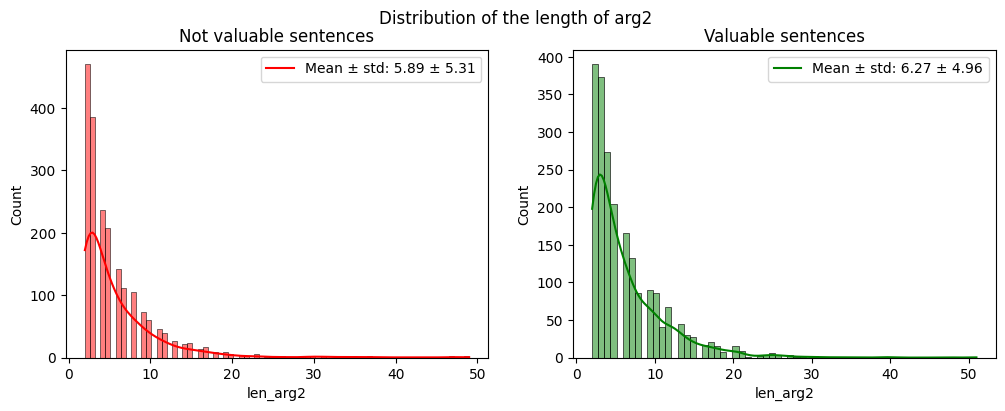

In [104]:
# distribution of the length of the arg2 for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean = final.groupby("is_valuable")["len_arg2"].mean()
std = final.groupby("is_valuable")["len_arg2"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable"] == 0]["len_arg2"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")

sns.histplot(final[final["is_valuable"] == 1]["len_arg2"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")


axes[0].legend(labels=[f"Mean ± std: {mean[0]:.2f} ± {std[0]:.2f}"])
axes[1].legend(labels=[f"Mean ± std: {mean[1]:.2f} ± {std[1]:.2f}"])

# Title
plt.suptitle("Distribution of the length of arg2")

plt.show()


After conducting the visualization, we discovered that there were essentially no differences in the token length between valuable sentences and non-valuable ones. This is likely due to the significant variability present in the sentences. Since our primary objective was to determine whether or not the sentences made sense this could have led to different sentence being classified in both the categories.

## Embedding

After conducting the visualization, we utilized a pretrained model for generating embeddings. Pretrained models are advantageous as they excel in capturing the contextual information of words and producing more comprehensive representations. This ensures a higher quality of embeddings for our analysis. In particular we decided to use *all-MiniLM-L6-v2*

In [107]:

model = SentenceTransformer('all-MiniLM-L6-v2')
final.loc[:, 'arg1'] = final.loc[:, 'arg1'].apply(lambda x: model.encode(x))
final.loc[:, 'rel'] = final.loc[:, 'rel'].apply(lambda x: model.encode(x))
final.loc[:, 'arg2'] = final.loc[:, 'arg2'].apply(lambda x: model.encode(x))

In [108]:
embeddings_arg1 = np.vstack(final.loc[:, 'arg1'].values)
embeddings_rel = np.vstack(final.loc[:, 'rel'].values)
embeddings_arg2 = np.vstack(final.loc[:, 'arg2'].values)

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_arg1 = tsne.fit_transform(embeddings_arg1)
tsne_rel = tsne.fit_transform(embeddings_rel)
tsne_arg2 = tsne.fit_transform(embeddings_arg2)

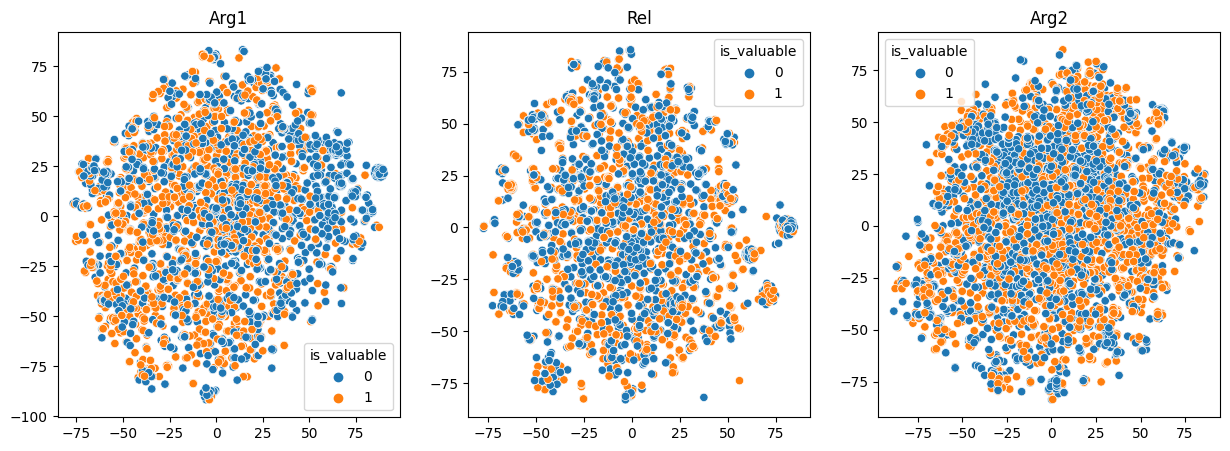

In [112]:
#scatter plot of the embeddings 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=tsne_arg1[:, 0], y=tsne_arg1[:, 1], hue=final['is_valuable'], ax=axes[0])
axes[0].set_title("Arg1")

sns.scatterplot(x=tsne_rel[:, 0], y=tsne_rel[:, 1], hue=final['is_valuable'], ax=axes[1])
axes[1].set_title("Rel")

sns.scatterplot(x=tsne_arg2[:, 0], y=tsne_arg2[:, 1], hue=final['is_valuable'], ax=axes[2])
axes[2].set_title("Arg2")

plt.show()


Based on the T-SNE representation, it appears that there are no distinct clusters in the data. This outcome is somewhat disappointing, but considering the high variability present in the annotated data, it is understandable.

In [40]:
# final.loc[:, 'negated']=final.loc[:, 'negated'].apply(lambda x: 1 if x==True else 0)
# final.loc[:, 'passive']=final.loc[:, 'passive'].apply(lambda x: 1 if x==True else 0)
# negated = np.expand_dims(final.loc[:, 'negated'].values, axis=1)
# passive = np.expand_dims(final.loc[:, 'passive'].values, axis=1)
confidence= final.loc[:, ['confidence']].values
len_arg1 = np.expand_dims(final.loc[:, 'len_arg1'].values, axis=1)
len_rel = np.expand_dims(final.loc[:, 'len_rel'].values, axis=1)
len_arg2 = np.expand_dims(final.loc[:, 'len_arg2'].values, axis=1)


In [41]:
# X = np.hstack([embeddings_arg1, embeddings_rel, embeddings_arg2, negated, passive, confidence])
X = np.hstack([embeddings_arg1, embeddings_rel, embeddings_arg2, confidence, len_arg1, len_rel, len_arg2])

In [54]:
X=final.drop(['is_valuable', 'sentence', 'arg1', 'rel', 'arg2', 'negated', 'passive'],axis=1)

In [42]:
y=final.loc[:, 'is_valuable'].astype(int)

## Model

For the classification task, we opted to use a random classifier. Ensemble methods, such as random classifiers, are renowned for their effectiveness in classification tasks. One advantage of ensemble methods is that they can be utilized without the need to scale the features, making them a convenient choice for our task.

In [56]:
# Create a Random Forest Classifier with desired parameters
rf_classifier = RandomForestClassifier(random_state=42)
score = cross_val_score(rf_classifier, X, y, cv=5,error_score='raise')
score

array([0.56115108, 0.55635492, 0.56354916, 0.52278177, 0.55395683])

In [117]:
rf=RandomForestClassifier(random_state=42)
rf.fit(X,y)

RandomForestClassifier(random_state=42)

The scores obtained from the random classifier were disappointingly low. Upon further analysis, we concluded that labeling complete sentences might not have been the best approach. This is because certain words within the sentences were causing them to lose their meaning, resulting in similar embedding representations with different labels. As a result, the classifier struggled to learn how to effectively perform the task.

# SECOND TRY WITH MORE CLASSIFIERS


In our second attempt, we decided to improve the quality of the data annotations. To achieve this, four of us manually selected 150 sentences and extracted corresponding arg1, rel, and arg2 components. We then evaluated the feasibility of each individual extraction separately. In order to minimize the variability introduced in the previous approach, we established a set of objective and stringent rules. This approach aimed to reduce subjectivity and guide the decision-making process.

To facilitate this process, we developed three separate classifiers, one for each extracted section. These classifiers were designed to classify each section and determine whether a sentence should be included based on positive results from all three classifiers.

By implementing these measures, we aimed to enhance the quality and consistency of the annotations, thereby reducing subjectivity and increasing objectivity in the decision-making process.

In [ ]:
final = pd.read_csv('../data/second_try_annotations.csv')

## Data Visualization

After annotating the data using the improved approach, we proceeded to perform visualization for the second time. During this analysis, we observed certain patterns. One notable observation was that the dataset for arg1 exhibited a relatively balanced distribution across the two categories. However, this balance was not reflected in the datasets for rel and arg2, as they displayed significant class imbalances. As a result, we recognized the need to address the class imbalance issue by adjusting the loss function for the classifiers associated with rel and arg2. This adjustment aimed to ensure that the models effectively learned from and handled the imbalanced data in a more appropriate manner.

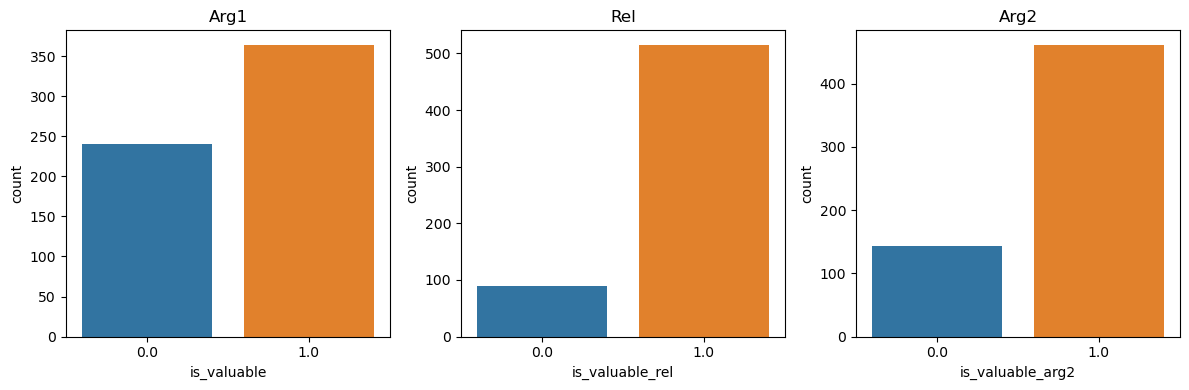

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.countplot(data=final, x='is_valuable', ax=axes[0])
axes[0].set_title('Arg1')
sns.countplot(data=final, x='is_valuable_rel', ax=axes[1])
axes[1].set_title('Rel')
sns.countplot(data=final, x='is_valuable_arg2', ax=axes[2])
axes[2].set_title('Arg2')
plt.tight_layout()
plt.show()


In [6]:
final["len_arg1"]=final["arg1"].apply(lambda x: len(word_tokenize(x)))
final["len_rel"]=final["rel"].apply(lambda x: len(word_tokenize(x)))
final["len_arg2"]=final["arg2"].apply(lambda x: len(word_tokenize(x)))

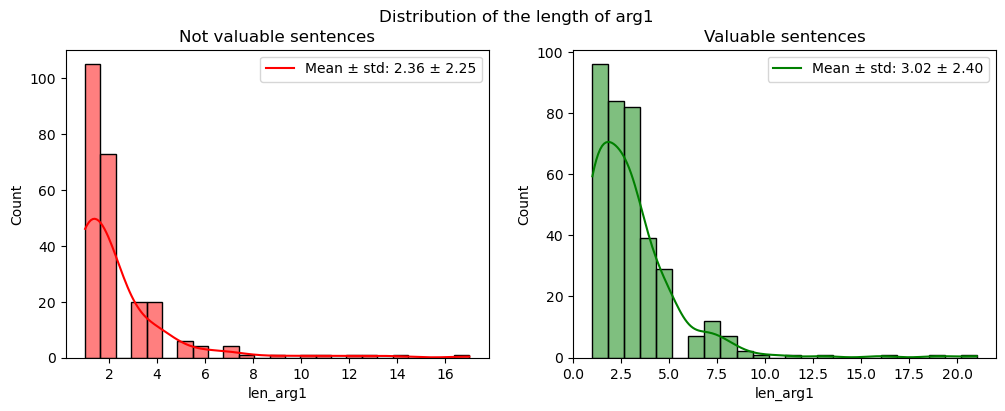

In [7]:
# distribution of the length of the arg1 for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean = final.groupby("is_valuable")["len_arg1"].mean()
std = final.groupby("is_valuable")["len_arg1"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable"] == 0]["len_arg1"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")

sns.histplot(final[final["is_valuable"] == 1]["len_arg1"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")


axes[0].legend(labels=[f"Mean ± std: {mean[0]:.2f} ± {std[0]:.2f}"])
axes[1].legend(labels=[f"Mean ± std: {mean[1]:.2f} ± {std[1]:.2f}"])

# Title
plt.suptitle("Distribution of the length of arg1")

plt.show()

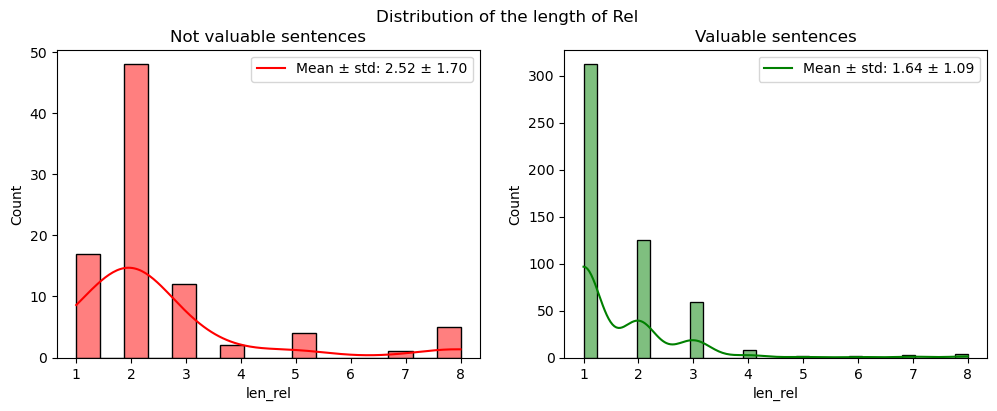

In [8]:
# distribution of the length of the rel for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean = final.groupby("is_valuable_rel")["len_rel"].mean()
std = final.groupby("is_valuable_rel")["len_rel"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable_rel"] == 0]["len_rel"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")

sns.histplot(final[final["is_valuable_rel"] == 1]["len_rel"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")


axes[0].legend(labels=[f"Mean ± std: {mean[0]:.2f} ± {std[0]:.2f}"])
axes[1].legend(labels=[f"Mean ± std: {mean[1]:.2f} ± {std[1]:.2f}"])

# Title
plt.suptitle("Distribution of the length of Rel")

plt.show()

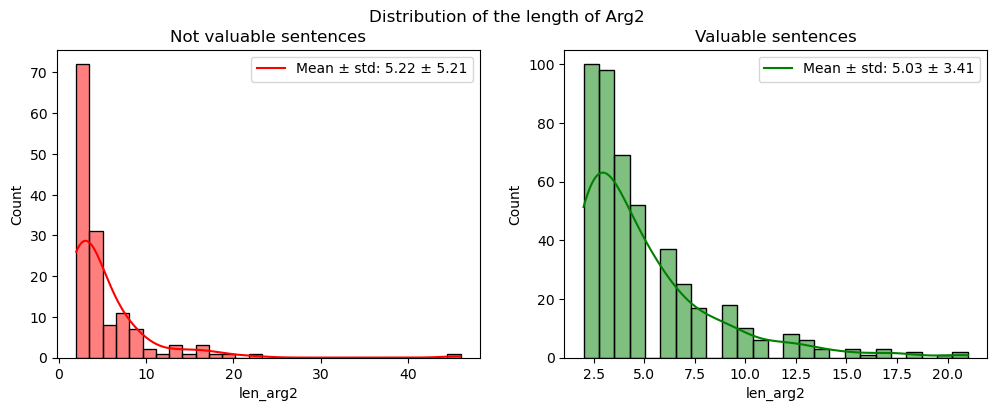

In [9]:
# distribution of the length of the arg2 for both valuable and not valuable sentences 

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mean = final.groupby("is_valuable_arg2")["len_arg2"].mean()
std = final.groupby("is_valuable_arg2")["len_arg2"].std()

# Plot the two subplots
sns.histplot(final[final["is_valuable_arg2"] == 0]["len_arg2"], kde=True, ax=axes[0], color='r', alpha=0.5)
axes[0].set_title("Not valuable sentences")

sns.histplot(final[final["is_valuable_arg2"] == 1]["len_arg2"], kde=True, ax=axes[1], color='g', alpha=0.5)
axes[1].set_title("Valuable sentences")


axes[0].legend(labels=[f"Mean ± std: {mean[0]:.2f} ± {std[0]:.2f}"])
axes[1].legend(labels=[f"Mean ± std: {mean[1]:.2f} ± {std[1]:.2f}"])

# Title
plt.suptitle("Distribution of the length of Arg2")

plt.show()

In terms of token length, when examining arg1, we observed a distribution that remains relatively similar between the two categories. However, for valuable sentences, there is a noticeable trend of having a higher token length. As for the relations, valuable relations tend to have shorter token lengths. On the other hand, for arg2, we didn't observe significant differences in token length between the categories.

It's important to note that during this separate evaluation, we encountered challenges in identifying non-suitable arg2 and rel instances compared to arg1. This difficulty could be attributed to our criteria of considering arg1 as non-meaningful when it contains imprecise references to objects, people, or events, such as pronouns or vague terms. This stricter criteria for arg1 might have contributed to the easier identification of non-suitable instances.

These findings suggested that token length can play a role in differentiating between valuable and non-valuable arg1 and relations.

In [10]:
main_pos_tags = {'Noun': ['NN', 'NNS', 'NNP', 'NNPS'],
                 'Pronoun': ['PRP', 'PRP$'],
                 'Adjective': ['JJ', 'JJR', 'JJS'],
                 'Verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                 'Adverb': ['RB', 'RBR', 'RBS'],
                 'Determiner': ['DT', 'PDT', 'WDT'],
                 'Numeral': ['CD']
                }

def count_main_pos_tags(sentence):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
    tag_counts = {tag_group: 0 for tag_group in main_pos_tags}
    for word, tag in pos_tags:
        for tag_group, tags in main_pos_tags.items():
            if tag in tags:
                tag_counts[tag_group] += 1
    return tag_counts


In [11]:
def for_class(df,x):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    if x=="arg1":
        db=df[[x,"is_valuable"]]
    elif x=="rel":
        db=df[[x,"is_valuable_rel"]]
    elif x=="arg2":
        db=df[[x,"is_valuable_arg2"]]
    db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
    db['main_pos_counts'] = db[x].apply(count_main_pos_tags)
    db = pd.concat([db.drop('main_pos_counts', axis=1), db['main_pos_counts'].apply(pd.Series)], axis=1)
    db["rel_nouns"]=db["Noun"]/db["length"]
    db["rel_pronouns"]=db["Pronoun"]/db["length"]
    db["rel_adjectives"]=db["Adjective"]/db["length"]
    db["rel_verbs"]=db["Verb"]/db["length"]
    db["rel_adverbs"]=db["Adverb"]/db["length"]
    db["rel_determiners"]=db["Determiner"]/db["length"]
    db["rel_numerals"]=db["Numeral"]/db["length"]
    if x=="rel":
        db_majority = db[db['is_valuable_rel'] == 1]  # Majority class
        db_minority = db[db['is_valuable_rel'] == 0]  # Minority class
        db_majority_undersampled = resample(db_majority, replace=False, n_samples=len(db_minority))
        db = pd.concat([db_majority_undersampled, db_minority]).reset_index(drop=True)
        db_aux=db.copy()
    else:
        db_aux=None
    db.loc[:, x] = db.loc[:, x].apply(lambda x: model.encode(x))
    embeddings_arg1 = np.vstack(db.loc[:, x].values)
    len_arg1 = np.expand_dims(db.loc[:, 'length'].values, axis=1)
    nouns=np.expand_dims(db.loc[:, 'Noun'].values, axis=1)
    pronouns=np.expand_dims(db.loc[:, 'Pronoun'].values, axis=1)
    adjectives=np.expand_dims(db.loc[:, 'Adjective'].values, axis=1)
    verbs=np.expand_dims(db.loc[:, 'Verb'].values, axis=1)
    rel_nouns=np.expand_dims(db.loc[:, 'rel_nouns'].values, axis=1)
    rel_pronouns=np.expand_dims(db.loc[:, 'rel_pronouns'].values, axis=1)
    rel_adjectives=np.expand_dims(db.loc[:, 'rel_adjectives'].values, axis=1)
    rel_verbs=np.expand_dims(db.loc[:, 'rel_verbs'].values, axis=1)
    rel_adverbs=np.expand_dims(db.loc[:, 'rel_adverbs'].values, axis=1)
    rel_determiners=np.expand_dims(db.loc[:, 'rel_determiners'].values, axis=1)
    rel_numerals=np.expand_dims(db.loc[:, 'rel_numerals'].values, axis=1)
    db= np.hstack([embeddings_arg1, len_arg1, nouns, pronouns, adjectives, verbs, rel_nouns, rel_pronouns, rel_adjectives, rel_verbs, 
                   rel_adverbs, rel_determiners, rel_numerals])
    
    return db, db_aux

In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2')
emb_df = final.copy()
emb_df.loc[:,'arg1'] = emb_df.loc[:, 'arg1'].apply(lambda x: model.encode(x))
emb_df.loc[:,'rel'] = emb_df.loc[:, 'rel'].apply(lambda x: model.encode(x))
emb_df.loc[:,'arg2'] = emb_df.loc[:, 'arg2'].apply(lambda x: model.encode(x))

In [13]:
embeddings_arg1 = np.vstack(emb_df.loc[:, 'arg1'].values)
embeddings_rel = np.vstack(emb_df.loc[:, 'rel'].values)
embeddings_arg2 = np.vstack(emb_df.loc[:, 'arg2'].values)

In [135]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne2_arg1 = tsne.fit_transform(embeddings_arg1)
tsne2_rel = tsne.fit_transform(embeddings_rel)
tsne2_arg2 = tsne.fit_transform(embeddings_arg2)

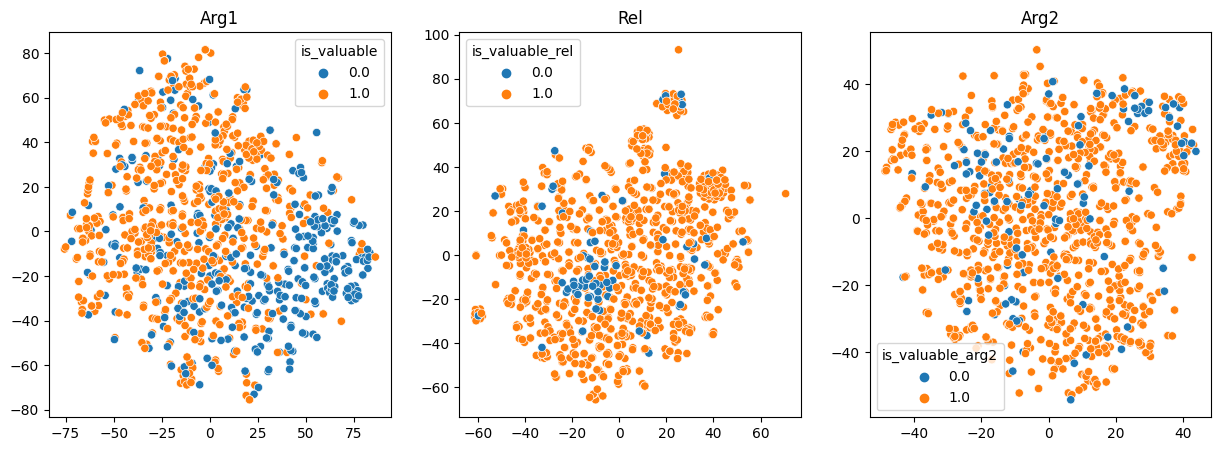

In [137]:
#scatter plot of the embeddings 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=tsne2_arg1[:, 0], y=tsne2_arg1[:, 1], hue=emb_df['is_valuable'], ax=axes[0])
axes[0].set_title("Arg1")

sns.scatterplot(x=tsne2_rel[:, 0], y=tsne2_rel[:, 1], hue=emb_df['is_valuable_rel'], ax=axes[1])
axes[1].set_title("Rel")

sns.scatterplot(x=tsne2_arg2[:, 0], y=tsne2_arg2[:, 1], hue=emb_df['is_valuable_arg2'], ax=axes[2])
axes[2].set_title("Arg2")

plt.show()


Based on the visualization of token length with the new annotations, we can observe some clusters in the data. In the case of arg1, non-valuable points appear to be more prominent on the right side of the visualization. For rel, non-valuable relations are relatively fewer compared to valuable ones, and they seem to be concentrated in the center of the visualization, while the valuable relations are more dispersed. It's important to exercise caution in interpreting these findings due to the class imbalance present in the data.

However, when it comes to arg2, no clear clusters are evident in the visualization. This remains a limitation of our annotation process, as even with stricter rules, the data points for arg2 do not exhibit clear separation or clustering patterns.

### Classifier for Arg1

In [14]:
db_arg1=for_class(final,"arg1")[0]
y_arg1=final["is_valuable"]

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_45709/4292264330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_45709/4292264330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['main_pos_counts'] = db[x].apply(count_main_pos_tags)


In [15]:
rf_arg1=RandomForestClassifier(random_state=42)
score = cross_val_score(rf_arg1, db_arg1, y_arg1, cv=10,error_score='raise')
print(f"the average accuracy was: {score.mean()} and the complete score was: {score}")

the average accuracy was: 0.8142896174863388 and the complete score was: [0.81967213 0.86885246 0.85245902 0.8852459  0.81666667 0.83333333
 0.86666667 0.76666667 0.7        0.73333333]


In [138]:
rf_arg1.fit(db_arg1,y_arg1)

RandomForestClassifier(random_state=42)

In [139]:
from joblib import dump
dump(rf_arg1, '../models/model_file.joblib')

['model_file.joblib']

In this case, we employed a random search technique to optimize the model and potentially achieve better performance.

In [216]:
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [i for i in range(2, 10)],
    'min_samples_leaf': [i for i in range(1, 10)],
    'min_impurity_decrease': [i for i in np.arange(0, 0.1, 0.01)] 
    }

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_arg1, param_distributions=param_grid, n_iter=100, cv=5, random_state=50, verbose=2)
random_search.fit(db_arg1, y_arg1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.6s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.6s
[CV] END max_depth=None, min_i

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=42, verbose=2)

In [218]:
rf_arg1_best=RandomForestClassifier(**random_search.best_params_,random_state=42)
score = cross_val_score(rf_arg1_best, db_arg1, y_arg1, cv=10,error_score='raise')
print(f"the average accuracy was: {score.mean()} and the complete score was: {score}")

the average accuracy was: 0.8126775956284155 and the complete score was: [0.83606557 0.85245902 0.83606557 0.86885246 0.83333333 0.81666667
 0.86666667 0.73333333 0.71666667 0.76666667]


In [28]:
from sklearn.metrics import f1_score
f1score = cross_val_score(rf_arg1,db_arg1, y_arg1, cv=10, scoring=make_scorer(f1_score))
print("F1 score:", f1score.mean())

F1 score: 0.8639836127969593


### Classifier for rel

In [16]:
db_rel, y_rel=for_class(final,"rel")
y_rel=y_rel["is_valuable_rel"]

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_45709/4292264330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_45709/4292264330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['main_pos_counts'] = db[x].apply(count_main_pos_tags)


In [17]:
rf_rel=RandomForestClassifier(random_state=42)
score_rel = cross_val_score(rf_rel, db_rel, y_rel, cv=10,error_score='raise')
print(f"the average accuracy was: {score_rel.mean()} and the complete score was: {score_rel}")

the average accuracy was: 0.7702614379084968 and the complete score was: [0.77777778 0.72222222 0.66666667 0.94444444 0.83333333 0.61111111
 0.77777778 0.72222222 0.70588235 0.94117647]


For the loss function of the rel and arg2 classifier, we have decided to penalize false positives. This means that when we predict that a sentence makes sense when it actually doesn't,and obviously we want to avoid including such nonsensical sentences in our map. Therefore, we created a custom loss function in which false positives are weighted five times more than false negatives.

The function has then been used in the randomsearch has an optimization parameter, since it is not possible, on sklearn to change the loss function used directly in the training phase.

In [18]:
def loss(y_true, y_pred):
    vect=y_true-y_pred
    loss=0
    for i in vect:
        if i>0:
            loss+=i
        if i<0:
            loss+=(-5*i)
    return loss

In [229]:
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [i for i in range(2, 10)],
    'min_samples_leaf': [i for i in range(1, 10)],
    'min_impurity_decrease': [i for i in np.arange(0, 0.1, 0.01)] 
    }

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_rel, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring=make_scorer(loss, greater_is_better=False), random_state=42, verbose=2)
random_search.fit(db_rel, y_rel)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   0.7s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   0.7s
[CV] END max_depth=None, min_i

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=42,
                   scoring=make_scorer(loss, greater_is_better=False),
                   verbose=2)

In [230]:
rf_rel_best=RandomForestClassifier(**random_search.best_params_,random_state=42)
score_rel_best = cross_val_score(rf_rel_best, db_rel, y_rel, cv=10,error_score='raise')
print(f"the average accuracy was: {score_rel_best.mean()} and the complete score was: {score_rel_best}")

the average accuracy was: 0.7584967320261438 and the complete score was: [0.77777778 0.72222222 0.72222222 0.88888889 0.66666667 0.66666667
 0.77777778 0.83333333 0.70588235 0.82352941]


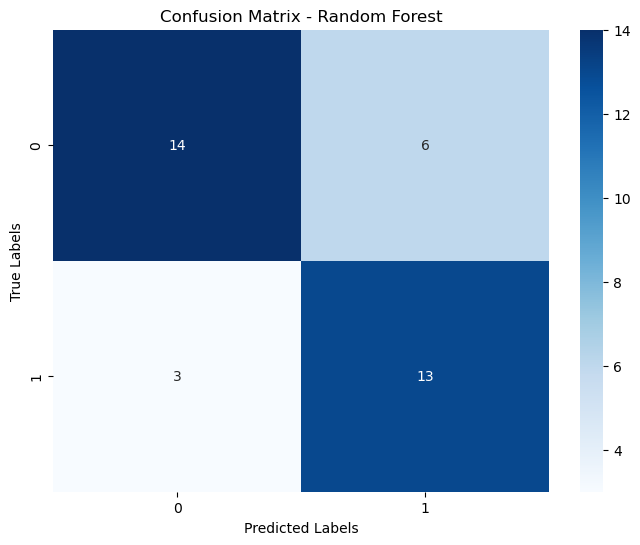

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_rel, y_rel, test_size=0.2, random_state=50)

# Initialize and train the Random Forest classifier
rf_rel.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_rel.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [31]:
f1score = cross_val_score(rf_rel,db_rel, y_rel, cv=10, scoring=make_scorer(f1_score))
print("F1 score:", f1score.mean())

F1 score: 0.7815535214848717


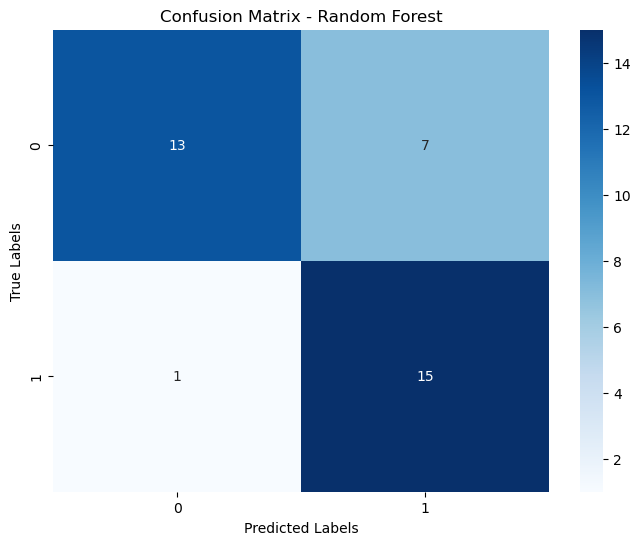

In [241]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_rel, y_rel, test_size=0.2, random_state=50)

# Initialize and train the Random Forest classifier
rf_rel_best.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_rel_best.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

The two confusion matrices represent the errors made in two scenarios: the first case using a symmetric loss function, and the second case using our custom loss function. It's important to note that these confusion matrices were created using a specific split of the data into training and test sets, which remained the same in both cases due to setting a random state. Upon analyzing the results, we observed that our model performs well in predicting the positive instances in both cases. However, it consistently struggles more when it comes to predicting the negative instances, even with the custom loss function that reduces the error for only one instance. This issue clearly stems from an imbalance in the categories.

### Classifier for Arg2

In [21]:
db_arg2=for_class(final,"arg2")[0]
y_arg2=final["is_valuable_arg2"]

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_45709/4292264330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["length"]=db[x].apply(lambda x: len(word_tokenize(x)))
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_45709/4292264330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['main_pos_counts'] = db[x].apply(count_main_pos_tags)


In [22]:
rf_arg2=RandomForestClassifier(random_state=42)
score_arg2 = cross_val_score(rf_arg2, db_arg2, y_arg2, cv=10,error_score='raise')
print(f"the average accuracy was: {score_arg2.mean()} and the complete score was: {score_arg2}")

the average accuracy was: 0.7682513661202186 and the complete score was: [0.78688525 0.7704918  0.73770492 0.75409836 0.8        0.76666667
 0.76666667 0.75       0.78333333 0.76666667]


In [152]:
rf_arg2.fit(db_arg2,y_arg2)

RandomForestClassifier(random_state=42)

In [236]:
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': [i for i in range(2, 10)],
    'min_samples_leaf': [i for i in range(1, 10)],
    'min_impurity_decrease': [i for i in np.arange(0, 0.1, 0.01)] 
    }

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_arg2, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring=make_scorer(loss, greater_is_better=False), random_state=42, verbose=2)
random_search.fit(db_arg2, y_arg2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_impurity_decrease=0.04, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.5s
[CV] END max_depth=None, min_impurity_decrease=0.01, min_samples_leaf=3, min_samples_split=9, n_estimators=600; total time=   1.5s
[CV] END max_depth=None, min_i

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   random_state=42,
                   scoring=make_scorer(loss, greater_is_better=False),
                   verbose=2)

In [237]:
rf_arg2_best=RandomForestClassifier(**random_search.best_params_,random_state=42)
score_arg2_best = cross_val_score(rf_arg2_best, db_arg2, y_arg2, cv=10,error_score='raise')
print(f"the average accuracy was: {score_arg2_best.mean()} and the complete score was: {score_arg2_best}")

the average accuracy was: 0.7649453551912568 and the complete score was: [0.7704918  0.7704918  0.73770492 0.75409836 0.76666667 0.76666667
 0.76666667 0.76666667 0.78333333 0.76666667]


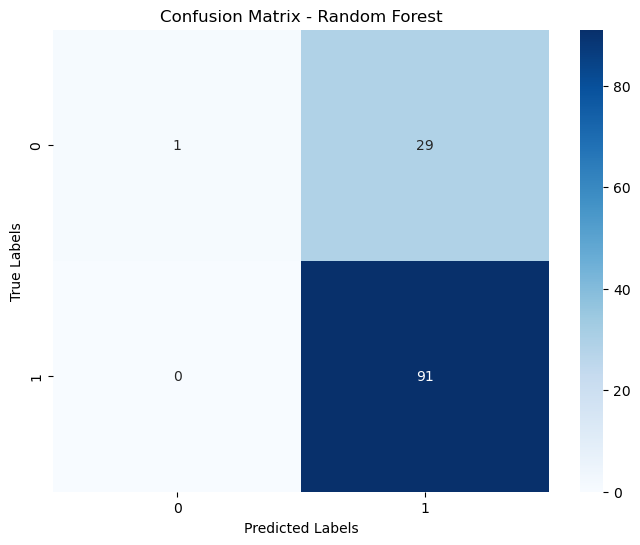

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_arg2, y_arg2, test_size=0.2, random_state=60)

# Initialize and train the Random Forest classifier
rf_arg2.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_arg2.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [30]:
f1score = cross_val_score(rf_arg2,db_arg2, y_arg2, cv=10, scoring=make_scorer(f1_score))
print("F1 score:", f1score.mean())

F1 score: 0.8677021191939195


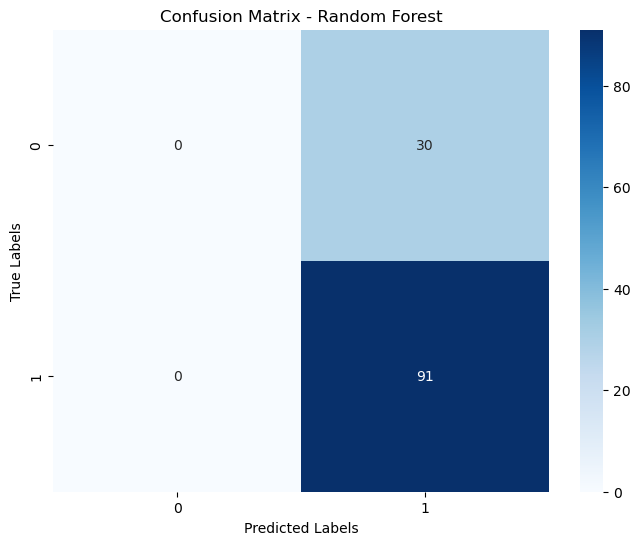

In [239]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(db_arg2, y_arg2, test_size=0.2, random_state=60)

# Initialize and train the Random Forest classifier
rf_arg2_best.fit(X_train, y_train)

# Predict labels for the test set
y_pred = rf_arg2_best.predict(X_test)

# Create the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

Compared to the results of the relations, we have even more disappointing outcomes in the confusion matrices related to the arguments2. In fact, in this particular data split, our model predicts almost all instances as 1, with only one exception. In the second case, with the weighted loss, the situation is even worse as it predicts all instances as 1. This outcome clearly indicates an imbalance in the data, but it also highlights the high variability in the sentences. Most of the time, it is challenging to find an argument2 that doesn't have its own sense or meaning when considered alone. The instances where arguments lack sense or meaning are relatively few in proportion, and perhaps the model is struggling to accurately identify what is wrong with those instances.

# NEW ATTEMPT WITH CLASSIFIER ON TOTAL SENTENCE

We made a final attempt to determine whether the improved labeling of the data was sufficient to enable the classifier to learn from the entire sentence, without considering the separation into the three principal components.

In [192]:
attempt=final.copy()
attempt["is_meaningful"]=[1 if sum(attempt.iloc[i,7:10])==3 else 0 for i in range(len(attempt))]
attempt.drop(["arg1","arg2","rel","is_valuable","is_valuable_rel","is_valuable_arg2"],axis=1,inplace=True)

<AxesSubplot: xlabel='is_meaningful', ylabel='count'>

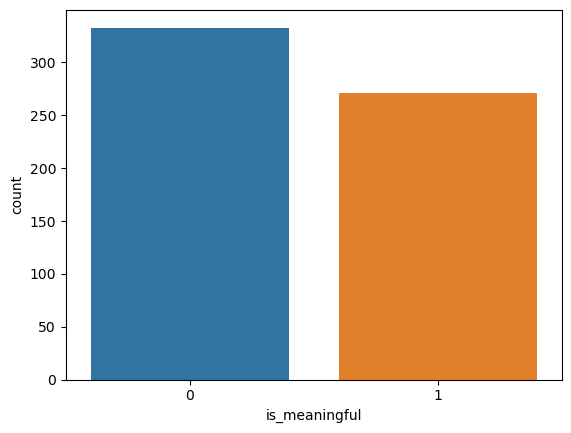

In [208]:
sns.countplot(x="is_meaningful", data=attempt)

In [206]:
def for_class_attempt(df):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    db = df.copy()
    db["length"]=db["sentence"].apply(lambda x: len(word_tokenize(x)))
    db['main_pos_counts'] = db["sentence"].apply(count_main_pos_tags)
    db = pd.concat([db.drop('main_pos_counts', axis=1), db['main_pos_counts'].apply(pd.Series)], axis=1)
    db["rel_nouns"]=db["Noun"]/db["length"]
    db["rel_pronouns"]=db["Pronoun"]/db["length"]
    db["rel_adjectives"]=db["Adjective"]/db["length"]
    db["rel_verbs"]=db["Verb"]/db["length"]
    db["rel_adverbs"]=db["Adverb"]/db["length"]
    db["rel_determiners"]=db["Determiner"]/db["length"]
    db["rel_numerals"]=db["Numeral"]/db["length"]
    db.loc[:, "sentence"] = db.loc[:, "sentence"].apply(lambda x: model.encode(x))
    embeddings_sentence = np.vstack(db.loc[:, "sentence"].values)
    len_sentence = np.expand_dims(db.loc[:, 'length'].values, axis=1)
    nouns=np.expand_dims(db.loc[:, 'Noun'].values, axis=1)
    pronouns=np.expand_dims(db.loc[:, 'Pronoun'].values, axis=1)
    adjectives=np.expand_dims(db.loc[:, 'Adjective'].values, axis=1)
    verbs=np.expand_dims(db.loc[:, 'Verb'].values, axis=1)
    rel_nouns=np.expand_dims(db.loc[:, 'rel_nouns'].values, axis=1)
    rel_pronouns=np.expand_dims(db.loc[:, 'rel_pronouns'].values, axis=1)
    rel_adjectives=np.expand_dims(db.loc[:, 'rel_adjectives'].values, axis=1)
    rel_verbs=np.expand_dims(db.loc[:, 'rel_verbs'].values, axis=1)
    rel_adverbs=np.expand_dims(db.loc[:, 'rel_adverbs'].values, axis=1)
    rel_determiners=np.expand_dims(db.loc[:, 'rel_determiners'].values, axis=1)
    rel_numerals=np.expand_dims(db.loc[:, 'rel_numerals'].values, axis=1)
    confidence=np.expand_dims(db.loc[:, 'confidence'].values, axis=1)
    passive=pd.get_dummies(db["passive"],drop_first=True)
    negated=pd.get_dummies(db["negated"],drop_first=True)
    db= np.hstack([embeddings_sentence, len_sentence, nouns, pronouns, adjectives, verbs, rel_nouns, rel_pronouns, 
                   rel_adjectives, rel_verbs, rel_adverbs, rel_determiners, rel_numerals, passive, negated, confidence])
    
    return db

In [207]:
db_sentence=for_class_attempt(attempt)
y_sentence=attempt["is_meaningful"]

In [209]:
rf_sentence=RandomForestClassifier(random_state=42)
score = cross_val_score(rf_sentence, db_sentence, y_sentence, cv=10,error_score='raise')
print(f"the average accuracy was: {score.mean()} and the complete score was: {score}")

the average accuracy was: 0.5360655737704918 and the complete score was: [0.60655738 0.57377049 0.63934426 0.54098361 0.46666667 0.58333333
 0.43333333 0.45       0.5        0.56666667]
